In [53]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad
import jax.numpy as jnp

plt.rcParams.update({'font.size': 22})

In [54]:
# [1] Doekemeijer, van der Hoek, van Wingerden, Closed-loop model-based wind farm control
# using FLORIS under time-varying inflow conditions, 2020, Renewable Energy

rho = 1.225 # density of air
D = 178.3  # radius of wind turbine blades; from [1]
A = np.pi*(D/2)**2 # swept area of wind turbine blades
p = 2. # power on yaw angle in power eqn. TO DO: look up real value
a = .2 # max is Betz limit=1/3; Bastankhah has values a=.1 to .33
Cp = 4.*a*(1.-a)**2 
Ct = 4*a*(1-a) # Bastankhah has values .4 to .9 -> a=.1 to .33 (wake deflection larger for larger Ct)

U_inf = 8. # [1]

ky = .05 # [1] wake expansion = .02 in Bastankhah

C0 = 1. - np.sqrt(1-Ct)
M0 = C0*(2.-C0)
E0 = C0**2 - 3.*np.exp(1./12.)*C0+3.*np.exp(1./3.)

x0 = 0.*D # [1] 1.088
sigma_z0 = np.sqrt(1./8.)*D 

In [76]:
# define variables
gamma = cp.Variable() # yaw angle

# location of downstream turbine
x = 6.*D
y = 0.

def get_sigma_y0(gamma):
    return sigma_z0*jnp.cos(gamma)

def get_theta(gamma):
    return .3*gamma*jnp.cos(gamma)*(1-jnp.sqrt(1-Ct*jnp.cos(gamma)))

def get_delta0(gamma):
    theta = get_theta(gamma)
    return x0*theta

def get_sigma_y(gamma):
    sigma_y0 = get_sigma_y0(gamma)
    return ky*(x-x0)+sigma_y0

def get_delta(gamma):
    sigma_y = get_sigma_y(gamma)
    sigma_y0 = get_sigma_y0(gamma)
    delta_log = jnp.log(((1.6+np.sqrt(M0))*(1.6*jnp.sqrt(sigma_y/sigma_y0)-np.sqrt(M0))) / 
                       ((1.6-np.sqrt(M0))*(1.6*jnp.sqrt(sigma_y/sigma_y0)+np.sqrt(M0))))
    delta0 = get_delta0(gamma)
    theta = get_theta(gamma)
    return delta0 + D*theta*E0/5.2*jnp.sqrt(sigma_y0/(ky*M0))*delta_log

def get_C(gamma):
    sigma_y = get_sigma_y(gamma)
    sigma_y0 = get_sigma_y0(gamma)    
    return 1. - jnp.sqrt(1. - sigma_y0*M0/sigma_y)

def get_u(gamma):
    C = get_C(gamma)
    delta = get_delta(gamma)
    sigma_y = get_sigma_y(gamma)
    return U_inf*(1.-C*jnp.exp(-.5*jnp.power((y-delta)/sigma_y, 2)))

def get_P2(gamma):
    u = get_u(gamma)
    gamma2 = 0.
    return .5*rho*A*Cp*jnp.cos(jnp.power(gamma2,2))*jnp.power(u,3)

In [77]:
gammaStars = []
P1s_predicted = []
P2s_predicted = []
Ps_predicted = []

gammas = np.array([0., 5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])*np.pi/180.
for gamma0 in gammas:
    # set up and solve problem
    P1 = .5*rho*A*Cp*U_inf**3*(np.cos(gamma0**2) - np.sin(gamma0**2)*(gamma**2-gamma0**2))
    dP2 = grad(get_P2)
    P2 = get_P2(gamma0) + dP2(gamma0)*(gamma-gamma0)
    P = P1 + P2
    u_ideal = U_inf
    P_ideal = 2.*np.sum(1./2.*rho*A*Cp*u_ideal**3)
    constraints = [gamma <= 50.*np.pi/180., gamma >= 0.] # constraining to positive yaw common
    prob = cp.Problem(cp.Minimize(P_ideal - P), constraints)
    # P.is_convex(), P.is_concave(), prob.is_dcp()
    prob.solve()
    gammaStar = gamma.value
    
    gammaStars.append(gammaStar)
    P1s_predicted.append(float(P1.value))
    P2s_predicted.append(float(P2.value))
    Ps_predicted.append(float(P1.value+P2.value))
    
gammaStars = np.array(gammaStars)
P1s_predicted = np.array(P1s_predicted)
P2s_predicted = np.array(P2s_predicted)
Ps_predicted = np.array(Ps_predicted)

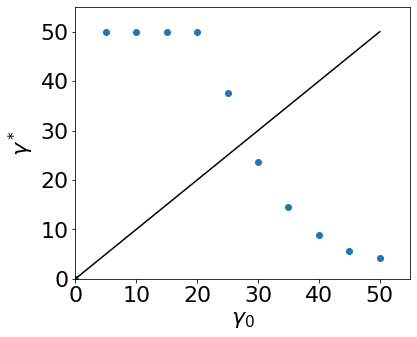

In [78]:
plt.figure(figsize=(6,5))
plt.xlim([0,55])
plt.xticks([0, 10, 20, 30, 40, 50])
plt.ylim([0,55])
plt.xlabel(r'$\gamma_0$')
plt.ylabel(r'$\gamma^*$')
plt.plot(gammas*180./np.pi,gammas*180./np.pi, color='k')
plt.scatter(gammas*180./np.pi, gammaStars*180./np.pi)
plt.savefig('gamma0', bbox_inches='tight')
plt.show()

In [79]:
gammaStars_iter = []

gamma0s = []
gamma0 = 25.*np.pi/180.
for k in range(10):
    # set up and solve problem
    P1 = .5*rho*A*Cp*U_inf**3*(np.cos(gamma0**2) - np.sin(gamma0**2)*(gamma**2-gamma0**2))
    dP2 = grad(get_P2)
    P2 = get_P2(gamma0) + dP2(gamma0)*(gamma-gamma0)
    P = P1 + P2
    u_ideal = U_inf
    P_ideal = 2.*np.sum(1./2.*rho*A*Cp*u_ideal**3)
    constraints = [gamma <= 50.*np.pi/180., gamma >= 0.] # constraining to positive yaw common
    prob = cp.Problem(cp.Minimize(P_ideal - P), constraints)
    # P.is_convex(), P.is_concave(), prob.is_dcp()
    prob.solve()
    gammaStar  = gamma.value

    gammaStars_iter.append(gammaStar)
    gamma0s.append(gamma0)
    gamma0 += .1*(gammaStar - gamma0)

gamma0s = np.array(gamma0s)
gammaStars_iter = np.array(gammaStars_iter)

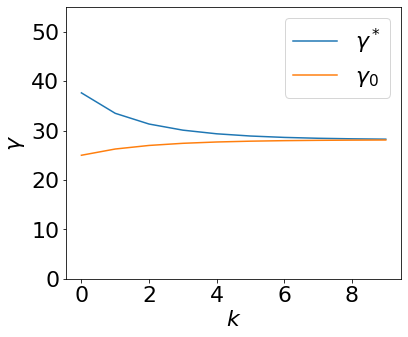

In [83]:
plt.figure(figsize=(6,5))
plt.ylim([0,55])
plt.xlabel(r'$k$')
plt.ylabel(r'$\gamma$')
plt.plot(gammaStars_iter*180./np.pi, label=r'$\gamma^*$')
plt.plot(gamma0s*180./np.pi, label=r'$\gamma_0$')
plt.legend()
plt.savefig('iter_relaxed', bbox_inches='tight')
plt.show()

In [84]:
gammaStar*180./np.pi

28.25544770262305

In [85]:
# grid search for comparison
gammas = np.array([0., 5., 10., 15., 20., 25., \
                   28., gammaStar*180./np.pi, 29., 30., 35., 40., 45., 50.])*np.pi/180.
P1s = []
P2s = []
Ps = []

for gamma_i in gammas:
    P1_i = .5*rho*A*Cp*U_inf**3*np.cos(gamma_i**2)
    P2_i = get_P2(gamma_i)
    P_i = P1_i+float(P2_i)
    P1s.append(P1_i)
    P2s.append(P2_i)
    Ps.append(P_i)

In [90]:
Ps = np.array(Ps)
np.max(Ps), gammas[np.argmax(Ps)]*180./np.pi

(6373803.360219317, 28.25544770262305)

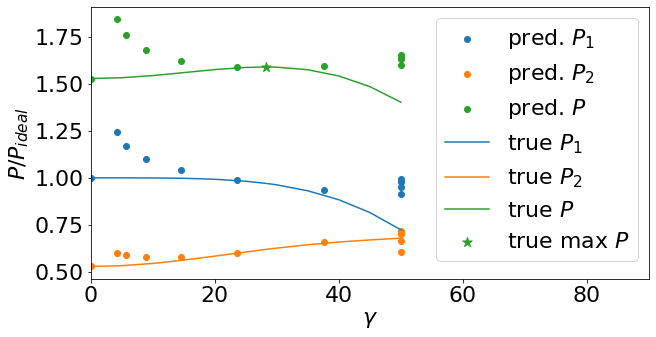

In [102]:
plt.figure(figsize=(10,5))
plt.scatter(gammaStars*180./np.pi, P1s_predicted/(P_ideal/2.), label=r'pred. $P_1$')
plt.scatter(gammaStars*180./np.pi, P2s_predicted/(P_ideal/2.), label=r'pred. $P_2$')
plt.scatter(gammaStars*180./np.pi, Ps_predicted/(P_ideal/2.), label=r'pred. $P$')
plt.plot(gammas*180./np.pi, P1s/(P_ideal/2.), label=r'true $P_1$')
plt.plot(gammas*180./np.pi, P2s/(P_ideal/2.), label=r'true $P_2$')
plt.plot(gammas*180./np.pi, Ps/(P_ideal/2.), label=r'true $P$')
plt.scatter(gammas[np.argmax(Ps)]*180./np.pi, np.max(Ps)/(P_ideal/2.), color='tab:green', marker="*", s=100, label=r'true max $P$')
plt.legend(loc='upper right')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$P/P_{ideal}$')
plt.xlim([0, 90])
plt.savefig('power', bbox_inches='tight')
plt.show()

## plot field w/ yaw

In [8]:
# [1] Doekemeijer, van der Hoek, van Wingerden, Closed-loop model-based wind farm control
# using FLORIS under time-varying inflow conditions, 2020, Renewable Energy

rho = 1.225 # density of air
D = 178.3  # radius of wind turbine blades; from [1]
A = np.pi*(D/2)**2 # swept area of wind turbine blades
p = 2. # power on yaw angle in power eqn. TO DO: look up real value
a = .2 # max is Betz limit=1/3; Bastankhah has values a=.1 to .33
Cp = 4.*a*(1.-a)**2 
Ct = 4*a*(1-a) # Bastankhah has values .4 to .9 -> a=.1 to .33 (wake deflection larger for larger Ct)

U_inf = 8. # [1]

ky = .05 # [1] wake expansion = .02 in Bastankhah

C0 = 1. - np.sqrt(1-Ct)
M0 = C0*(2.-C0)
E0 = C0**2 - 3.*np.exp(1./12.)*C0+3.*np.exp(1./3.)

x0 = -1.*D # [1] 1.088

In [9]:
def get_u(x,y, gamma, x0):
    sigma_z0 = np.sqrt(1./8.)*D 
    sigma_y0 = sigma_z0*np.cos(gamma)

    theta = .3*gamma/np.cos(gamma)*(1-np.sqrt(1-Ct*np.cos(gamma)))
    delta0 = (x-x0)*theta # Annoni wrong -> see Bastankhah (7.4)
    sigma_y = ky*(x-x0)+sigma_y0
    delta_log = np.log(((1.6+np.sqrt(M0))*(1.6*np.sqrt(sigma_y/sigma_y0)-np.sqrt(M0))) / 
                       ((1.6-np.sqrt(M0))*(1.6*np.sqrt(sigma_y/sigma_y0)+np.sqrt(M0))))
    delta = delta0 + D*theta*E0/5.2*np.sqrt(sigma_y0/(ky*M0))*delta_log

    C = 1. - np.sqrt(1. - sigma_y0*M0/sigma_y)
    
    return U_inf*(1.-C*np.exp(-.5*((y-delta)/sigma_y)**2))

In [10]:
N = 1000
x_min = x0+1.*D
x_max = 12*D
x = np.linspace(x_min, x_max, N)
y_min = -1.5*D
y_max = 1.5*D
y = np.linspace(y_min, y_max, N)
X, Y = np.meshgrid(x, y)
   
U1s = []
gammas = np.pi/180.*np.array([0., 10., 20., 30.])
for gamma in gammas:
    U1 = np.zeros((N,N))
    for i in range(N):
        xi = x[i]
        U1[i,:] = get_u(xi, y, gamma, x0)
    U1s.append(U1)

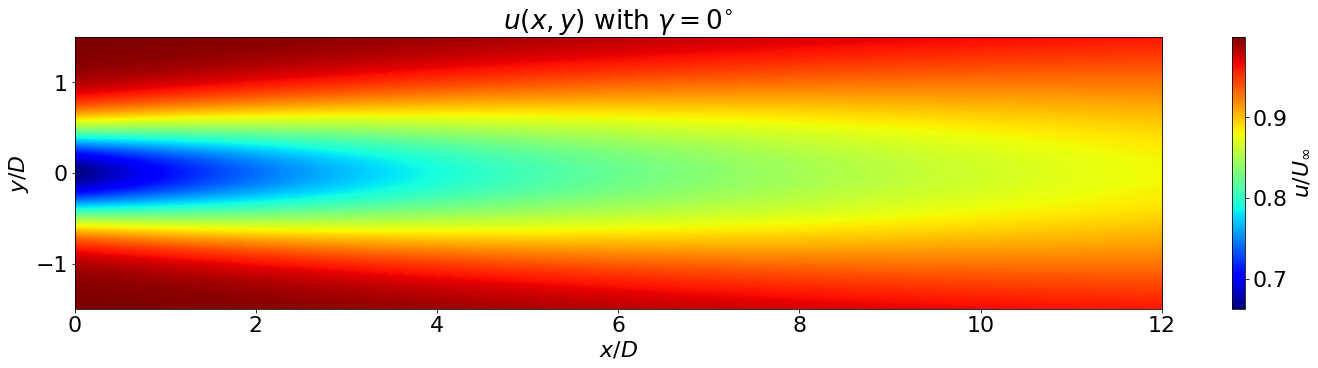

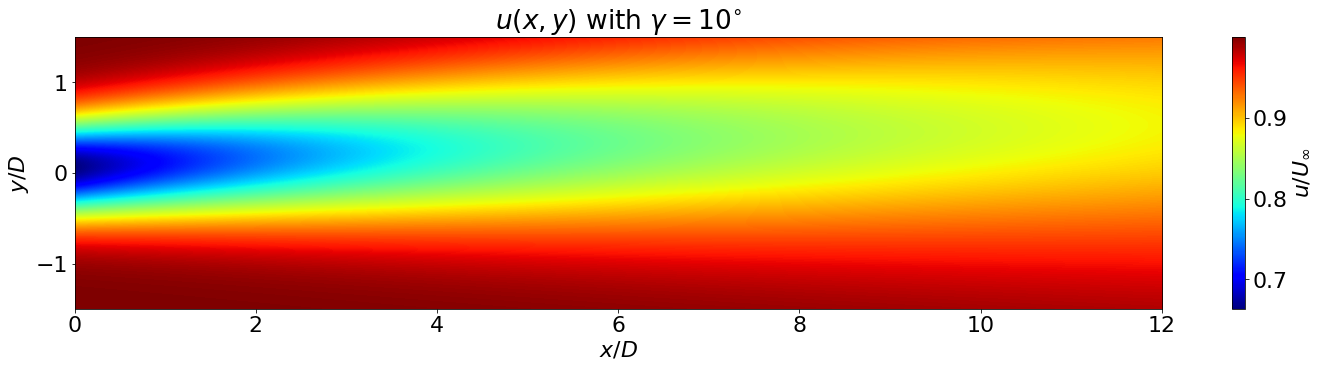

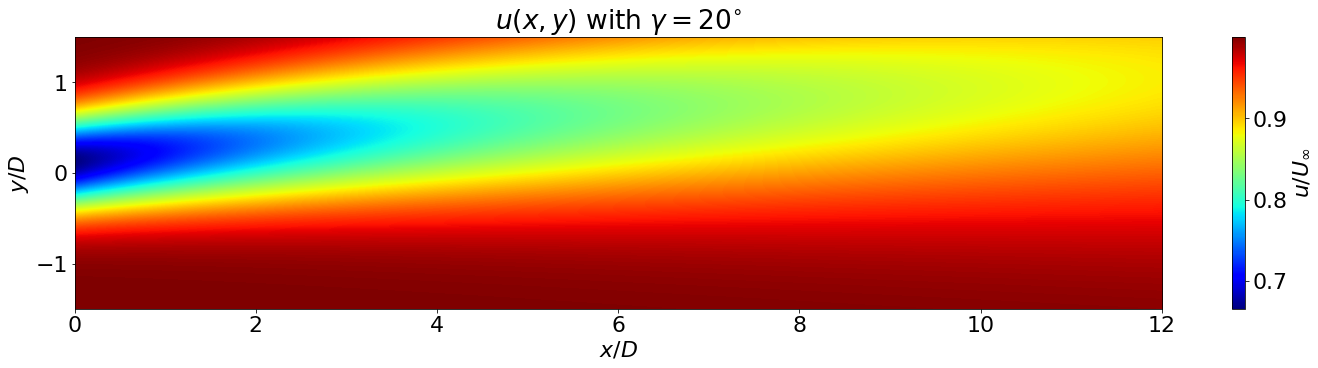

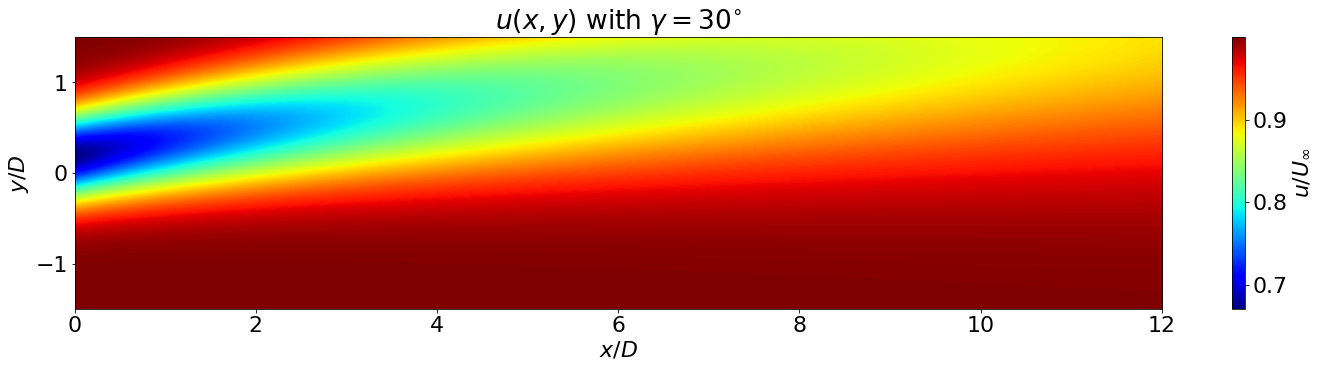

In [11]:
for i in range(len(U1s)):
    U1 = U1s[i]
    gamma = gammas[i]*180./np.pi
    plt.rcParams["figure.figsize"] = (25,5)
    plt.rcParams.update({'font.size': 22})

    plt.imshow(U1.T/U_inf, extent=[x_min/D, x_max/D, y_max/D, y_min/D], cmap='jet')
    ax=plt.gca()
    ax.invert_yaxis()
    plt.xlabel(r'$x/D$')
    plt.ylabel(r'$y/D$')
    cbar = plt.colorbar()
    cbar.set_label(r'$u/U_{\infty}$')
    plt.title(r'$u(x,y)$ with $\gamma=%d^{\circ}$'%np.round(gamma))
    plt.savefig('flowField_turbine1_gamma%d'%np.round(gamma), bbox_inches='tight')
    plt.show()

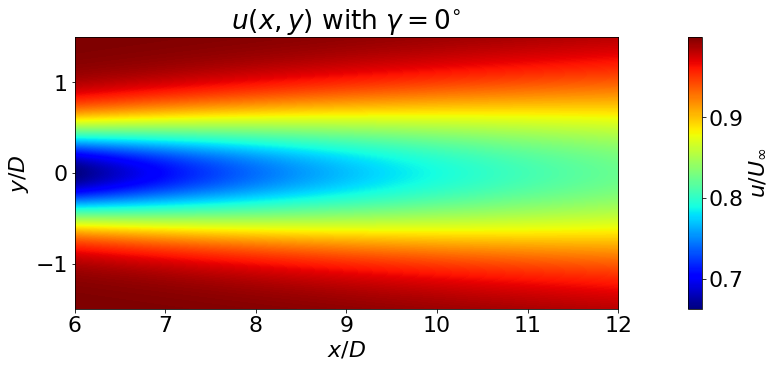

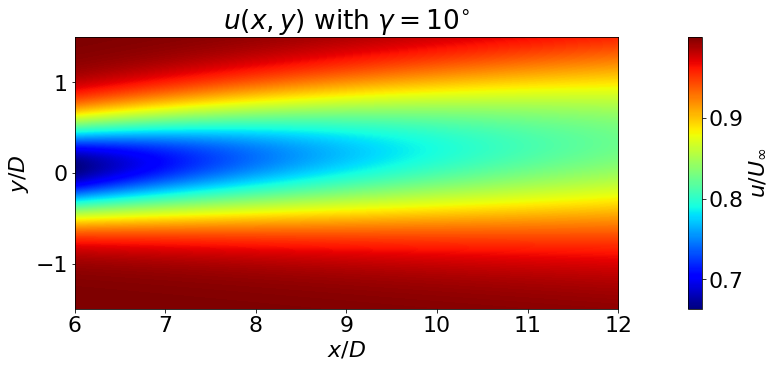

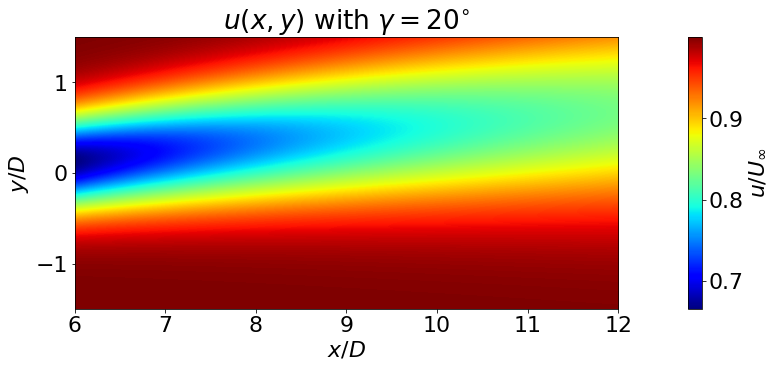

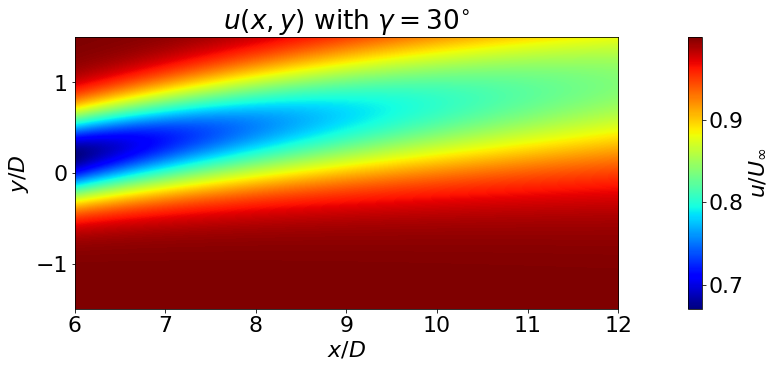

In [12]:
x0 = 5.*D
x_min = x0+1.*D
x_max = 12*D
x = np.linspace(x_min, x_max, int(N/2))
y_min = -1.5*D
y_max = 1.5*D
y = np.linspace(y_min, y_max, N)

U2s = []
gammas = np.pi/180.*np.array([0., 10., 20., 30.])
for gamma in gammas:
    U2 = np.zeros((int(N/2),N))
    for i in range(int(N/2)):
        xi = x[i]
        U2[i,:] = get_u(xi, y, gamma, x0)
    U2s.append(U2)
    
for i in range(len(U2s)):
    U2 = U2s[i]
    gamma = gammas[i]*180./np.pi
    plt.rcParams["figure.figsize"] = (25,5)
    plt.rcParams.update({'font.size': 22})

    plt.imshow(U2.T/U_inf, extent=[x_min/D, x_max/D, y_max/D, y_min/D], cmap='jet')
    ax=plt.gca()
    ax.invert_yaxis()
    plt.xlabel(r'$x/D$')
    plt.ylabel(r'$y/D$')
    cbar = plt.colorbar()
    cbar.set_label(r'$u/U_{\infty}$')
    plt.title(r'$u(x,y)$ with $\gamma=%d^{\circ}$'%np.round(gamma))
    plt.savefig('flowField_turbine2_gamma%d'%np.round(gamma), bbox_inches='tight')
    plt.show()

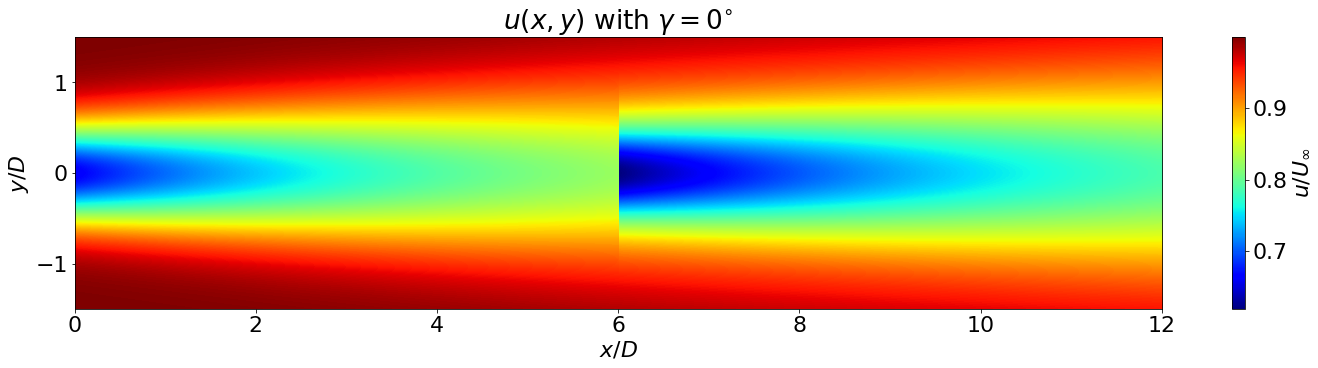

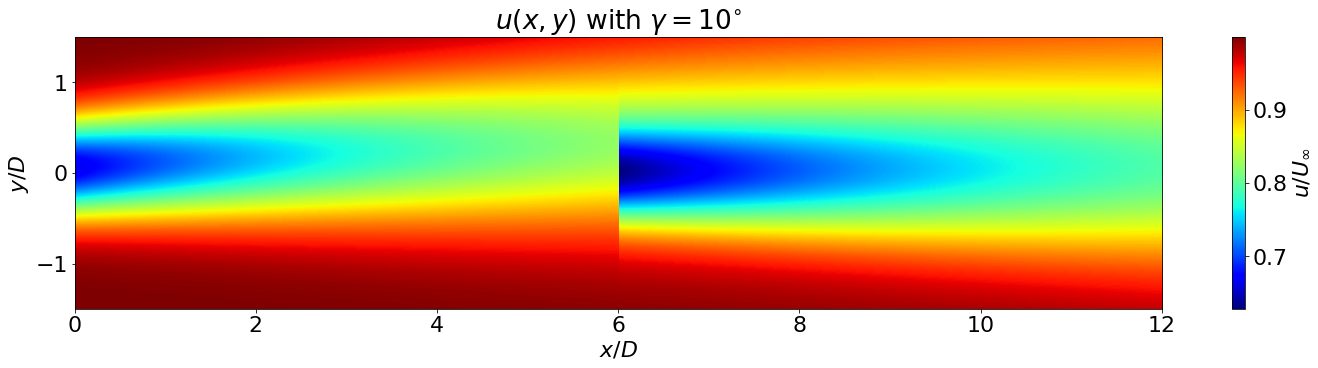

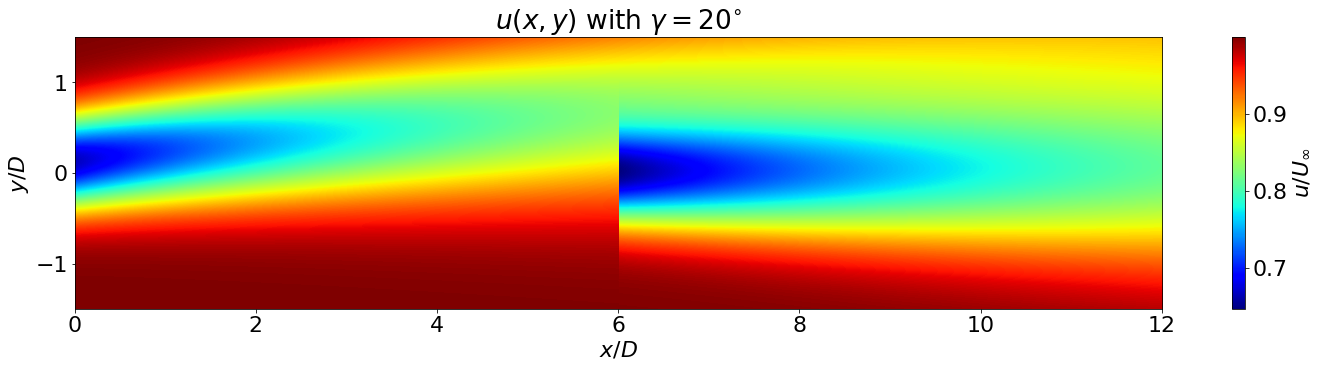

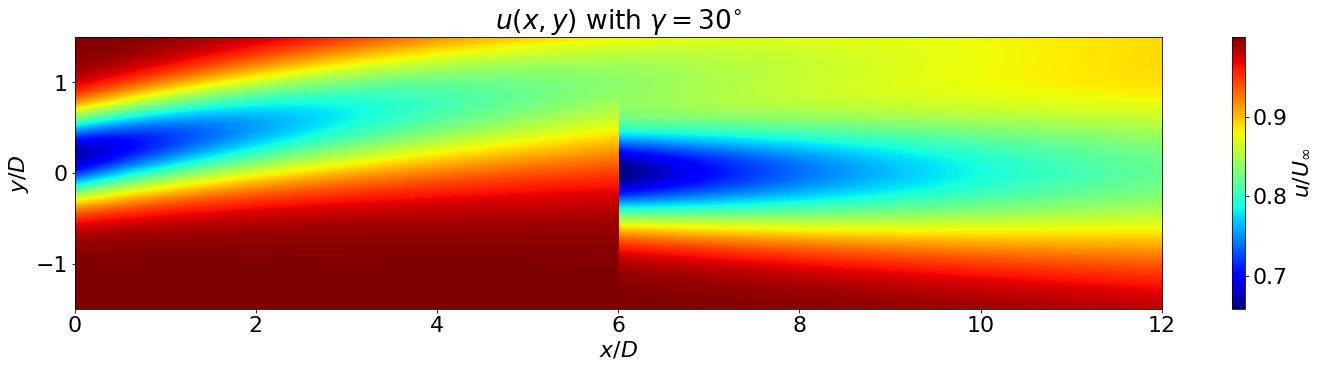

In [13]:
x0 = 0.*D
x_min = x0
x_max = 12*D
x = np.linspace(x_min, x_max, N)
y_min = -1.5*D
y_max = 1.5*D
y = np.linspace(y_min, y_max, N)

for i in range(len(U1s)):
    U1 = U1s[i]
    U2 = U2s[0]
    gamma = gammas[i]*180./np.pi
    
    U_tot = np.zeros((N,N))
    U_tot[:500,:] = U1[:500,:]
    U_tot[500:,:] = U_inf*(1.-np.sqrt((1.-U1[500:,:]/U_inf)**2 + (1.-U2/U_inf)**2))

    plt.rcParams["figure.figsize"] = (25,5)
    plt.rcParams.update({'font.size': 22})

    plt.imshow(U_tot.T/U_inf, extent=[x_min/D, x_max/D, y_max/D, y_min/D], cmap='jet')
    ax=plt.gca()
    ax.invert_yaxis()
    plt.xlabel(r'$x/D$')
    plt.ylabel(r'$y/D$')
    cbar = plt.colorbar()
    cbar.set_label(r'$u/U_{\infty}$')
    plt.title(r'$u(x,y)$ with $\gamma=%d^{\circ}$'%np.round(gamma))
    plt.savefig('flowField_twoTurbines_gamma%d'%np.round(gamma), bbox_inches='tight')
    plt.show()